In [11]:
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/extensions')
sys.path
nltk.data.path = ['/vol/medic02/users/ag6516/nltk_data']
import csv
import pandas as pd
from read_data import read_csv_into_df

In [3]:
fields = ['Accession', 'Clinical history', 'Comment', 'Report text']
dir = ('/vol/medic02/users/ag6516/x_ray_fracture_localisation/')#
# dir = ('/Users/Aydan/PhD/x_ray_fracture_localisation/')

with open(dir + 'data/Reports/XKNEB_Jan_Dec_2015_anon.csv', 'rU') as csvfile:
    data1 = csv.reader(csvfile, delimiter=',')
    headers1 = data1.next()

with open(dir + 'data/Reports/XKNEB_Jan_Dec_2016_anon.csv', 'rU') as csvfile:
    data2 = csv.reader(csvfile, delimiter=',')
    headers2 = data2.next()

# with open(dir + 'data/Reports/XKNEB_Jan_Jul_2017_anon.csv', 'rU') as csvfile:
#     data3 = csv.reader(csvfile, delimiter=',')
#     headers3 = data3.next()

cols1 = [headers1.index(item) for item in fields]
cols2 = [headers2.index(item) for item in fields]
# cols3 = [headers3.index(item) for item in fields]

In [4]:
df1 = read_csv_into_df(dir + 'data/Reports/XKNEB_Jan_Dec_2015_anon.csv', fields, cols1)
df2 = read_csv_into_df(dir + 'data/Reports/XKNEB_Jan_Dec_2016_anon.csv', fields, cols2)

In [5]:
df = pd.concat([df1,df2])
print df.count()

Accession           3576
Clinical history    2232
Comment             2402
Report text         3576
dtype: int64


In [34]:
# Check for missing information
df_nans = df[df.isnull().any(axis=1)]
df_nans.to_csv('missing_info.csv', sep=',')

In [35]:
df.to_csv('cleaned_reports.csv', sep=',')

In [12]:
# Basic filtering and stats
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import random
random.seed(123)
np.random.seed(123)

reports = []
labels = []
words = []
for i, row in df.iterrows():
    report = row['Report text'].decode('utf-8').lower()
    
    # Replace unnecessary punctuation 
    for char in ['~', '"']:
        report = report.replace(char, '')
        
    for char in ['!', '?', ';', ':', '.']:
        report = report.replace(char, ' . ')
    
    for char in ['(', ')', ',', '/']:
        report = report.replace(char, ' , ')
        
    # Tokenize
    report_tok = word_tokenize(report)
    
    # Remove stopwords
    filtered_report = [word for word in report_tok if word not in stopwords.words('english')]
    
    reports.append(filtered_report)
    labels.append(row['Accession'])
    [words.append(word) for word in filtered_report]

print 'Vocab length: ', len(sorted(set(words)))
print 'Avg no. of appearances: ', len(words)/len(sorted(set(words)))
fdist_all = nltk.FreqDist(words)
freqs = [freq for _, freq in fdist_all.most_common()]
print 'STD: ', np.std(freqs)
#print fdist_all.hapaxes()

Vocab length:  2158
Avg no. of appearances:  41
STD:  349.019096469


Populating the interactive namespace from numpy and matplotlib
['.', 'knee', 'joint', 'xr', 'medial', 'changes', 'degenerative', 'seen', 'space', ',', 'right', 'patellofemoral', 'left', 'joints', 'change', 'compartment', 'previous', 'bilaterally', 'noted', 'loss', 'comparison', 'narrowing', 'spaces', 'compartments', 'tibiofemoral', 'mild', 'bilateral', 'osteophyte', 'imaging', 'bony', 'significant', 'moderate', 'osteophytosis', 'formation', 'within', 'lateral', 'made', 'knees', 'tibial', 'femoral', 'minor', 'osteoarthritic', 'marked', 'evidence', 'severe', 'preserved', 'acute', 'appearances', 'normal', 'reduction']


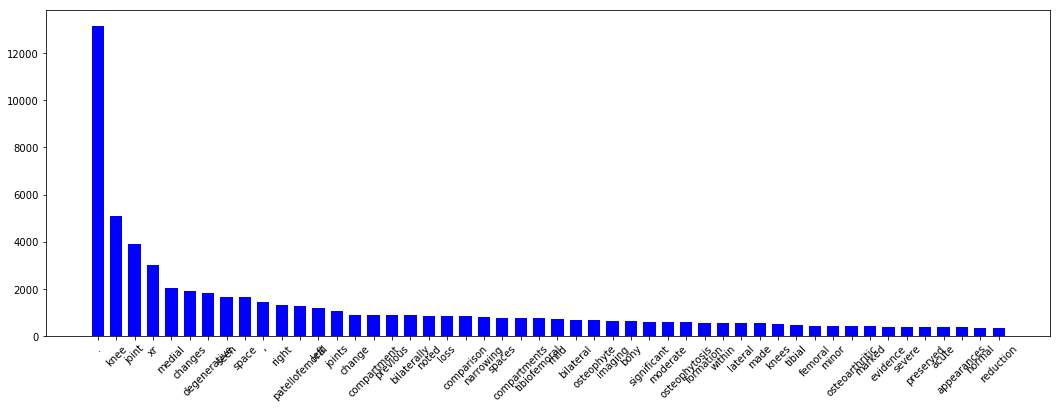

In [54]:
# Vocab evaluation
import matplotlib.pyplot as plt
#%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

hist = [(word,freq) for word, freq in fdist_all.most_common(50)]
#fdist_all.plot(50)

words = [str(word) for word in zip(*hist)[0]]
print words
counts = range(len(words))
frequency = zip(*hist)[1]

plt.bar(counts, frequency, 1/1.5, color="blue", align='center')
plt.xticks(counts, words, rotation=45)
fig = plt.gcf()

In [55]:
# Generate Doc2Vec embeddings for reports
import gensim
from gensim.models.doc2vec import LabeledSentence

class DocIterator(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc, tags=[self.labels_list[idx]])
            
it = DocIterator(reports, labels)

In [56]:
# Train model
model = gensim.models.Doc2Vec(size=300, min_count=0, alpha=0.025, min_alpha=0.025)
model.build_vocab(it)
#training of model
for epoch in range(10):
    print 'iteration ' +str(epoch+1)
    model.train(it, total_examples=model.corpus_count, epochs=model.iter)
    model.alpha -= 0.002
    model.min_alpha = model.alpha
    model.train(it, total_examples=model.corpus_count, epochs=model.iter)
#saving the created model
model.save('doc2vec.model')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


In [68]:
# Test model
pd.options.display.max_colwidth = 4000
label_sample = random.choice(labels)
report_sample = df.loc[df['Accession'] == label_sample]['Report text']
print report_sample.to_string()

most_similar = model.docvecs.most_similar(label_sample)
print "\nMost similar documents:"

for label, _ in most_similar:
    print (df.loc[df['Accession'] == label]['Report text']).to_string()
    print ''

181    XR Knee Both : Moderately to severe degenerative changes are noted in both tibiofemoral joint and both patellofemoral joint with osteophytes, sclerosis and  almost complete loss of medial compartmental joint space narrowing , more marked on the left.

Most similar documents:
876    XR Knee Both : Moderate degenerative changes are noted in both tibiofemoral joint and  both patellofemoral joint with osteophytes, sclerosis and medial compartmental joint space narrowing more marked on the left.

149    XR Knee Both : \nLeft knee\nSevere degenerative changes are noted in the tibiofemoral joint and patellofemoral joint with sclerosis, osteophytes  and almost complete loss of compartmental joint space.\nRight knee\nMarked degenerative changes are noted in tibiofemoral joint and patellofemoral joint with  sclerosis osteophytes and lateral compartmental  joint space narrowing.

1623    XR Knee Both : Moderate degenerative changes noted in both tibiofemoral joint and both patellofemoral j

1310  
  XR Knee Both : \nBilateral TKR prostheses  
  in situ with no complication seen and  
  alignment maintained, however there is soft tissue  
  swelling and suprapatellar heterotopic calcification noted.


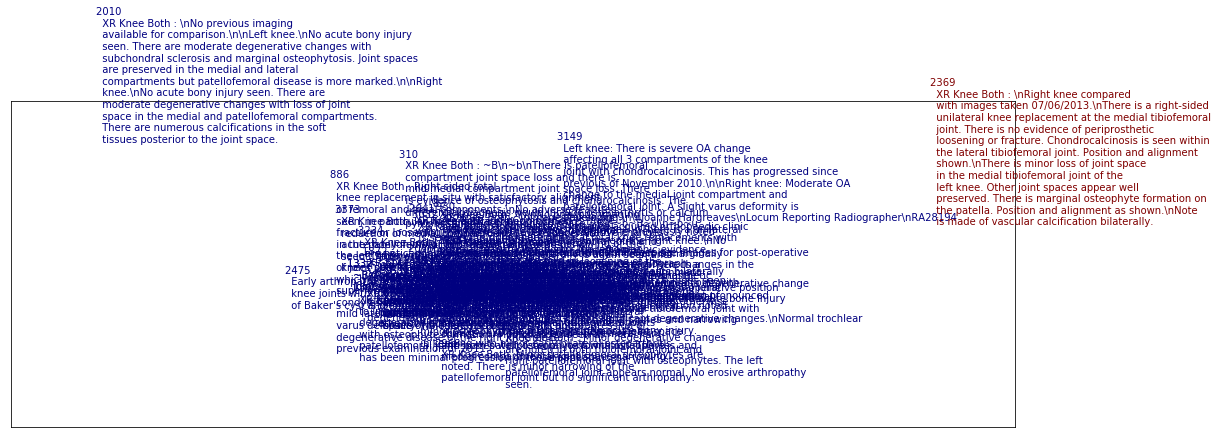

In [87]:
# Cluster documents using K-means
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

num_clusters = 2
num_samples = 50

label_samples = random.choice(labels, num_samples)
report_samples = []
vectors = []
for label in label_samples:
    report_samples.append(df.loc[df['Accession'] == label]['Report text'])
    vectors.append(model.docvecs[label])

report_samples_linebreaks = []
for report in report_samples:
    words = report.to_string().split()
    new_r = []
    for i, word in enumerate(words):
        new_r.append(word)
        if i%7==0:
            new_r.append(' \n ')
    report_samples_linebreaks.append(' '.join(new_r))

print report_samples_linebreaks[1]

# docvecs = model.docvecs
kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
kmeans.fit(vectors)

reduced_data = PCA(n_components=2).fit_transform(vectors)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

plt.figure(1)
plt.clf()

colours = plt.cm.jet(np.linspace(0, 1, num_clusters))

for i, x, y in zip(range(num_samples), reduced_data[:, 0], reduced_data[:, 1]):
    plt.annotate(report_samples_linebreaks[i], xy=(x, y), xytext=(0, 0), textcoords='offset points', color=colours[kmeans.labels_[i]])

#plt.title('K-means Clustering of Knee X-ray Reports (reduced with PCA)\n')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()